<a href="https://colab.research.google.com/github/nehakanjamala/EczemaClassification-CNNModel/blob/code/eczema_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Import Libraries and Load Data

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
import random


# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# Define dataset paths
ECZEMA_PATH = "/content/drive/My Drive/furi/dataset/Eczema"
NORMAL_PATH = "/content/drive/My Drive/furi/dataset/Normal"

# Check if directories exist
if not os.path.exists(ECZEMA_PATH) or not os.path.exists(NORMAL_PATH):
    print("Error: Dataset paths do not exist. Check your Google Drive path.")
else:
    print("Directories found.")

# Image parameters
IMG_SIZE = (128, 128) #pixel sizes (might want to increase size)
BATCH_SIZE = 32 #number of images processed in one training

Mounted at /content/drive
Directories found.


Step 2: Data augmentation and preprocessing

In [ ]:
# Data augmentation & preprocessing
datagen = ImageDataGenerator(
    #pixels normally range from 0-255 but we normalize to 0-1 to make training easier
    rescale=1./255,
    #30% of data set for validation (helps to check for overfitting by presenting the model new unseen data)
    validation_split=0.3
)

val_test_datagen = ImageDataGenerator(
    #pixels normally range from 0-255 but we normalize to 0-1 to make training easier
    rescale=1./255,
    validation_split=0.5 #Splits 30% into two equal parts
)

Step 3: Load Data into Training and Validation Set

In [ ]:
# Load data directly from drive rather than storing in memory
train_data = datagen.flow_from_directory(
    "/content/drive/My Drive/furi/dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', #classes only 2 cuz between eczema and non-eczema
    subset='training' #only uses training set (not put in validation set)
)

val_data = datagen.flow_from_directory(
    "/content/drive/My Drive/furi/dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle= False
)

test_data = datagen.flow_from_directory(
    "/content/drive/My Drive/furi/dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle= False
)

#Save the best model
checkpoint = ModelCheckpoint(
    "my_model.keras",
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode="max",  # Higher accuracy is better
    verbose=1
)

Found 2201 images belonging to 2 classes.
Found 2201 images belonging to 2 classes.
Found 942 images belonging to 2 classes.


Step 4: Build CNN

In [ ]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)), #32 filters that have a pixel size of 3x3 and relu helps with non-linearality
    MaxPooling2D(2,2), #reduces features and only keeps the strongest ones (uses a 2x2 window to keep the strongest features)
    #repeat for another layer
    Conv2D(64, (3,3), activation='relu'), #features are more complex so we need more filters with 3x3 kernel
    MaxPooling2D(2,2),
    #repeat for another layer
    Conv2D(128, (3,3), activation='relu'), #features are more complex so we need more filters with 3x3 kernel
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'), #features are more complex so we need more filters with 3x3 kernel
    MaxPooling2D(2,2),
    Conv2D(512, (3,3), activation='relu'), #features are more complex so we need more filters with 3x3 kernel
    MaxPooling2D(2,2),
    Flatten(), #converts from 2d to 1d
    Dense(256, activation='relu'), #connects hidden layer using 256 neurons and applying the relu activation to each neuron
    Dropout(0.7), #drops 70% of neurons to prevent overfitting
    Dense(1, activation='sigmoid') #only needs one neuron and sigmoid (classifying based on 0-1) cuz binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 5: Compile Model and Train Model

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), #adjust weights by 0.0001 during training for better convergence(learns faster, less loss (how confident a model is), generalizes well)
              loss='binary_crossentropy', #best one for binary classification
              metrics=['accuracy']) #tracks accuracy of training and validation

#We might want to add a test set as well for final evaluation

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5, #how many times it goes thru the dataset to train
    verbose=1, #displays detailed output (0 is for no output and 2 is for compact output)
    callbacks=[checkpoint]
)
#Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5240 - loss: 0.6638
Epoch 1: val_accuracy improved from -inf to 0.88642, saving model to my_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.5257 - loss: 0.6627 - val_accuracy: 0.8864 - val_loss: 0.3273
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8993 - loss: 0.2779
Epoch 2: val_accuracy improved from 0.88642 to 0.95684, saving model to my_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8994 - loss: 0.2775 - val_accuracy: 0.9568 - val_loss: 0.1245
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9358 - loss: 0.1682
Epoch 3: val_accuracy did not improve from 0.95684
69/69 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9360 - loss: 0.1678 - val_accuracy: 0.9382 - val_loss: 0.1597
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9541 - loss: 0.1212
Epoch 4: val_accuracy did not improve from 0.95684
69/69 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy:

Step 6: Plot Results

Training accuracy: [0.6428896188735962, 0.9068605303764343, 0.9513857364654541, 0.9577465057373047, 0.9700136184692383]
Validation accuracy: [0.8864152431488037, 0.9568377733230591, 0.9382098913192749, 0.9445706605911255, 0.9763743877410889]
Test Accuracy: 0.9904
Test Loss: 0.0274


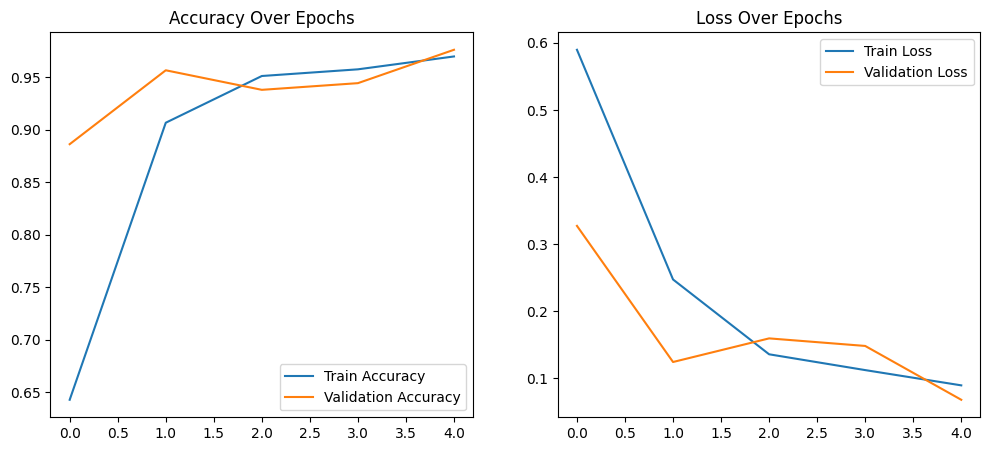

69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 579ms/step


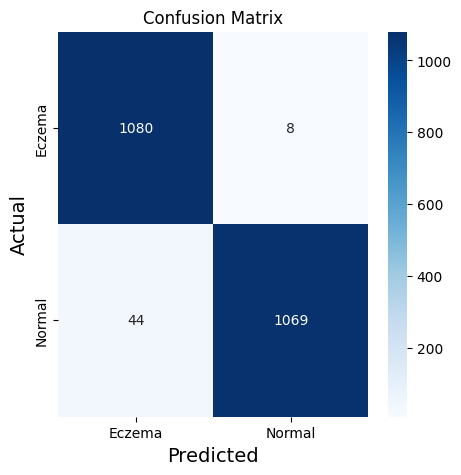

              precision    recall  f1-score   support

      Eczema       0.96      0.99      0.98      1088
      Normal       0.99      0.96      0.98      1113

    accuracy                           0.98      2201
   macro avg       0.98      0.98      0.98      2201
weighted avg       0.98      0.98      0.98      2201



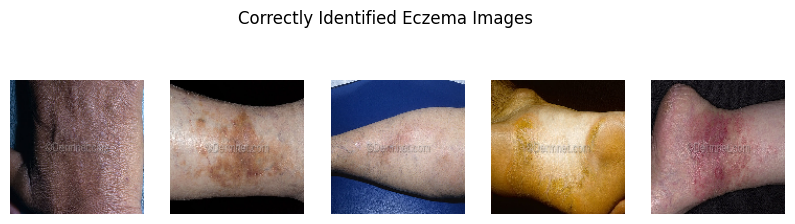

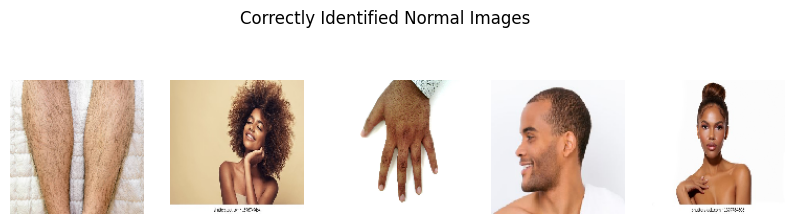

Model saved to Google Drive!


In [ ]:
# Evaluate model
plt.figure(figsize=(12, 5)) #creating a figure this big
plt.subplot(1, 2, 1) # there is gonna be 1 row of graphs, with 2 columns, select 1st plot
plt.plot(history.history['accuracy'], label='Train Accuracy') #plots train accuracy over epochs
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  #plots validation accuracy over epochs
print("Training accuracy:", history.history['accuracy'])
print("Validation accuracy:", history.history['val_accuracy'])
plt.legend() #displays legend for graph
plt.title('Accuracy Over Epochs') #displays title

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

plt.subplot(1, 2, 2)  # there is gonna be 1 row of graphs, with 2 columns, select 2nd plot
plt.plot(history.history['loss'], label='Train Loss') #plots train loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss') #plots validation loss over epochs
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Get prediction and true labels from the validation set
y_true = val_data.classes
y_pred = model.predict(val_data)
y_pred = np.round(y_pred).astype(int)
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Eczema', 'Normal'], yticklabels=['Eczema', 'Normal'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix')
plt.show()

#Print out classification report
print(classification_report(y_true, y_pred, target_names=['Eczema', 'Normal']))

# Get the indices of correctly classified images
correct_indices = np.where(y_true == y_pred)[0]

# Separate eczema and normal correctly classified indices
eczema_correct = [idx for idx in correct_indices if y_true[idx] == 0]  # 0 for Eczema
normal_correct = [idx for idx in correct_indices if y_true[idx] == 1]  # 1 for Normal

# Randomly select 5 images from each class
eczema_samples = random.sample(eczema_correct, min(5, len(eczema_correct)))
normal_samples = random.sample(normal_correct, min(5, len(normal_correct)))

# Function to display selected images
def display_images(indices, title):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        img_path = val_data.filepaths[idx]  # Get the file path
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img = image.img_to_array(img) / 255.0  # Normalize

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Display eczema and normal skin images
display_images(eczema_samples, "Correctly Identified Eczema Images")
display_images(normal_samples, "Correctly Identified Normal Images")

# Save model
model.save("/content/drive/My Drive/furi/dataset/eczema_classifier.h5")
print("Model saved to Google Drive!")
